In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy.linalg import svd, eig, pinv
from mpl_toolkits.mplot3d import Axes3D

In [11]:
# Parameters
sigma = 10.0
beta = 8.0 / 3.0
rho = 28.0

In [13]:
# Initial Conditions
dt = 0.001
t = np.arange(0, 20 + dt, dt)
x0 = [-8, 8, 27]

In [12]:
def lorenz_system(t, x):
    dx1 = sigma * (x[1] - x[0])
    dx2 = x[0] * (rho - x[2]) - x[1]
    dx3 = x[0] * x[1] - beta * x[2]
    return [dx1, dx2, dx3]

In [14]:
# Solve the ODE
sol = solve_ivp(lorenz_system, (t[0], t[-1]), x0, t_eval=t)
X_full = sol.y

# Snapshot matrices
X = X_full[:, :-1]
Y = X_full[:, 1:]
Gamma = np.zeros((1, X.shape[1]))  # dummy control input
Omega = np.vstack((X, Gamma))

In [15]:
# SVD of Omega
U_tilde, S_tilde_vals, Vh_tilde = svd(Omega, full_matrices=False)
p = 10
U_tilde = U_tilde[:, :p]
S_tilde = np.diag(S_tilde_vals[:p])
V_tilde = Vh_tilde[:p, :].T

# Partition U_tilde
n = X.shape[0]
U_tilde1 = U_tilde[:n, :]
U_tilde2 = U_tilde[n:, :]

In [16]:
#  SVD of Y
U_hat, S_hat_vals, Vh_hat = svd(Y, full_matrices=False)
r = 10
U_hat = U_hat[:, :r]
S_hat = np.diag(S_hat_vals[:r])
V_hat = Vh_hat[:r, :].T

In [17]:
#  Compute A_bar and B_bar
A_bar = Y @ V_tilde @ pinv(S_tilde) @ U_tilde1.T
B_bar = Y @ V_tilde @ pinv(S_tilde) @ U_tilde2.T

A_tilde = U_hat.T @ A_bar @ U_hat
B_tilde = U_hat.T @ B_bar

In [19]:
#  Eigenvalue decomposition
eigvals, W = eig(A_tilde)

#  DMD modes
Phi = Y @ V_tilde @ pinv(S_tilde) @ U_tilde1.T @ U_hat @ W

In [20]:
# DMD Time Reconstruction

omega = np.log(np.where(np.abs(eigvals) > 1e-10, eigvals, 1e-10)) / dt
time_dynamics = np.zeros((len(eigvals), X.shape[1]), dtype=complex)

for i in range(X.shape[1]):
    time_dynamics[:, i] = np.exp(omega * i * dt)

b = pinv(Phi) @ X[:, 0]
X_dmd = Phi @ (time_dynamics * b[:, np.newaxis])


Eigenvalues of A_tilde (DMDc approximation of system):
  λ1: 0.999966 + 0.000000j
  λ2: 0.999799 + 0.005693j
  λ3: 0.999799 + -0.005693j


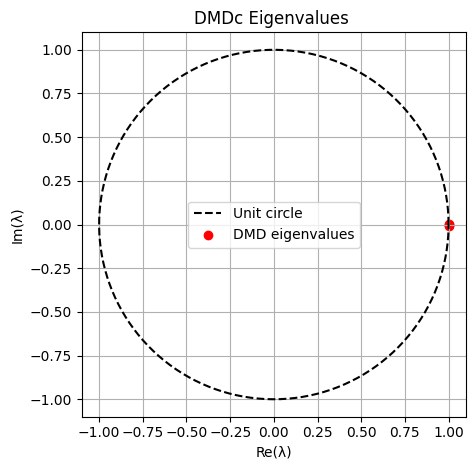

In [26]:
# DMD Eigenvalues
print("\nEigenvalues of A_tilde (DMDc approximation of system):")
for i, lam in enumerate(eigvals):
    print(f"  λ{i+1}: {lam.real:.6f} + {lam.imag:.6f}j")
plt.figure()
theta = np.linspace(0, 2 * np.pi, 300)
plt.plot(np.cos(theta), np.sin(theta), 'k--', label='Unit circle')
plt.scatter(eigvals.real, eigvals.imag, color='red', label='DMD eigenvalues')
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title("DMDc Eigenvalues ")
plt.gca().set_aspect('equal')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

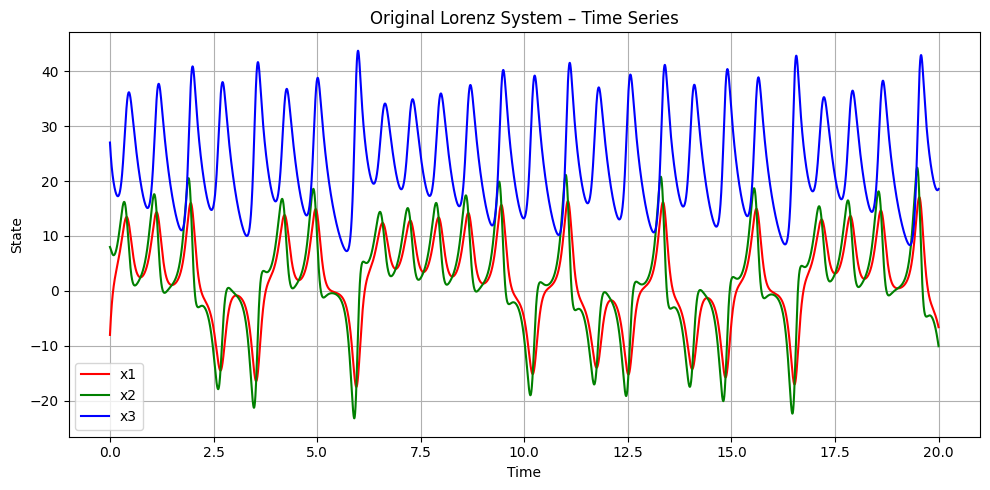

In [23]:
# Time-Series of True Lorenz System
plt.figure(figsize=(10, 5))
plt.plot(t, X_full[0], label="x1", color="r")
plt.plot(t, X_full[1], label="x2", color="g")
plt.plot(t, X_full[2], label="x3", color="b")
plt.title("Original Lorenz System – Time Series")
plt.xlabel("Time")
plt.ylabel("State")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

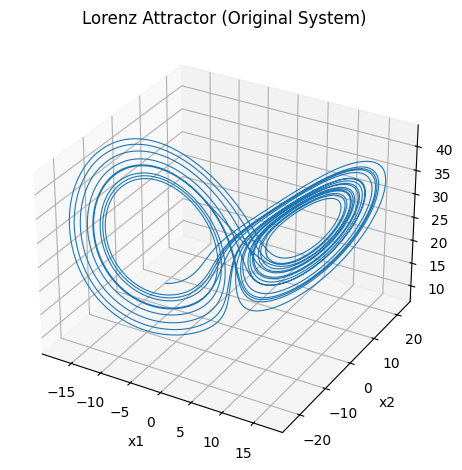

In [21]:
# 3D Lorenz Attractor
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(X_full[0], X_full[1], X_full[2], lw=0.8)
ax.set_title("Lorenz Attractor (Original System)")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("x3")
plt.tight_layout()
plt.show()